In [85]:
#FUNCTIONS

#Functions provided in Pseudocode
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager
import os
import pandas as pd

def initialize_lattice(size):
    # Create a 2D array 'lattice' of dimensions size x size, initialized to 0
    lattice = np.zeros((size, size), dtype=int)
    return lattice

def compute_neighbor_indices(size):
    # Create an empty dictionary to store neighbor indices
    neighbor_indices = {}
    
    # Loop over each cell in the lattice
    for x in range(size):
        for y in range(size):
            # Calculate the neighbors with periodic boundary conditions
            neighbors = [
                ((x - 1) % size, y),   # Left neighbor
                ((x + 1) % size, y),   # Right neighbor
                (x, (y - 1) % size),   # Top neighbor
                (x, (y + 1) % size)    # Bottom neighbor
            ]
            # Store neighbors for each position in the dictionary
            neighbor_indices[(x, y)] = neighbors
            
    return neighbor_indices

def calculate_interaction_energy(lattice, site, particle, neighbor_indices, epsilon_AA, epsilon_BB, epsilon_AB):
    # Extract the coordinates of the site
    x, y = site
    # Initialize interaction energy
    interaction_energy = 0

    # Iterate over each neighbor of the site
    for neighbor in neighbor_indices[(x, y)]:
        neighbor_particle = lattice[neighbor]
        
        # If there's a particle at the neighboring site
        if neighbor_particle != 0:
            if particle == 1:  # Particle A
                if neighbor_particle == 1:
                    interaction_energy += epsilon_AA
                else:  # Neighbor is Particle B
                    interaction_energy += epsilon_AB
            else:  # Particle B
                if neighbor_particle == 2:
                    interaction_energy += epsilon_BB
                else:  # Neighbor is Particle A
                    interaction_energy += epsilon_AB
                    
    return interaction_energy

import numpy as np

def attempt_move(lattice, N_A, N_B, N_empty, neighbor_indices, params):
    # Extract lattice size and parameters
    size = lattice.shape[0]
    N_sites = size * size
    beta = 1 / params['T']
    epsilon_A = params['epsilon_A']
    epsilon_B = params['epsilon_B']
    epsilon_AA = params['epsilon_AA']
    epsilon_BB = params['epsilon_BB']
    epsilon_AB = params['epsilon_AB']
    mu_A = params['mu_A']
    mu_B = params['mu_B']

    # Decide whether to add or remove a particle
    if np.random.rand() < 0.5:  # Attempt to add a particle
        if N_empty == 0:
            return N_A, N_B, N_empty  # No empty sites available

        # Select a random empty site
        empty_sites = np.argwhere(lattice == 0)
        site = tuple(empty_sites[np.random.randint(len(empty_sites))])

        # Decide which particle to add
        if np.random.rand() < 0.5:
            particle = 1  # Particle A
            mu = mu_A
            epsilon = epsilon_A
            N_s = N_A
        else:
            particle = 2  # Particle B
            mu = mu_B
            epsilon = epsilon_B
            N_s = N_B

        # Calculate the change in energy
        delta_E = epsilon + calculate_interaction_energy(lattice, site, particle, neighbor_indices, epsilon_AA, epsilon_BB, epsilon_AB)
        acc_prob = min(1, (N_empty / (N_s + 1)) * np.exp(-beta * (delta_E - mu)))

        # Attempt the move based on acceptance probability
        if np.random.rand() < acc_prob:
            lattice[site] = particle
            if particle == 1:
                N_A += 1
            else:
                N_B += 1
            N_empty -= 1

    else:  # Attempt to remove a particle
        if N_sites - N_empty == 0:
            return N_A, N_B, N_empty  # No particles to remove

        # Select a random occupied site
        occupied_sites = np.argwhere(lattice != 0)
        site = tuple(occupied_sites[np.random.randint(len(occupied_sites))])
        particle = lattice[site]

        # Set parameters based on particle type
        if particle == 1:
            mu = mu_A
            epsilon = epsilon_A
            N_s = N_A
        else:
            mu = mu_B
            epsilon = epsilon_B
            N_s = N_B

        # Calculate the change in energy
        delta_E = -epsilon - calculate_interaction_energy(lattice, site, particle, neighbor_indices, epsilon_AA, epsilon_BB, epsilon_AB)
        acc_prob = min(1, (N_s / (N_empty + 1)) * np.exp(-beta * (delta_E + mu)))

        # Attempt the move based on acceptance probability
        if np.random.rand() < acc_prob:
            lattice[site] = 0  # Remove particle
            if particle == 1:
                N_A -= 1
            else:
                N_B -= 1
            N_empty += 1

    return N_A, N_B, N_empty

import numpy as np

def run_simulation(size, n_steps, params):
    # Initialize lattice and neighbor indices
    lattice = initialize_lattice(size)
    neighbor_indices = compute_neighbor_indices(size)
    N_sites = size * size

    # Initialize particle counts and empty site count
    N_A = 0
    N_B = 0
    N_empty = N_sites

    # Arrays to store coverage over time
    coverage_A = np.zeros(n_steps)
    coverage_B = np.zeros(n_steps)

    # Run the simulation for the specified number of steps
    for step in range(n_steps):
        # Attempt a move and update counts
        N_A, N_B, N_empty = attempt_move(lattice, N_A, N_B, N_empty, neighbor_indices, params)
        
        # Calculate coverage and store it
        coverage_A[step] = N_A / N_sites
        coverage_B[step] = N_B / N_sites

    return lattice, coverage_A, coverage_B



def plot_lattice(lattice, ax, title):
    size = lattice.shape[0]
    
    # Loop through the lattice to plot particles
    for x in range(size):
        for y in range(size):
            if lattice[x, y] == 1:
                # Plot a red circle for Particle A
                ax.plot(x + 0.5, y + 0.5, 'o', color='red', markersize=6)
            elif lattice[x, y] == 2:
                # Plot a blue circle for Particle B
                ax.plot(x + 0.5, y + 0.5, 'o', color='blue', markersize=6)
    
    # Set axis limits and labels
    ax.set_xlim(0, size)
    ax.set_ylim(0, size)
    ax.set_xticks(np.arange(0, size + 1, 1))
    ax.set_yticks(np.arange(0, size + 1, 1))
    ax.set_xticklabels([])  # Hide x-axis labels
    ax.set_yticklabels([])  # Hide y-axis labels
    
    # Set the grid to show the major ticks for clearer grid lines
    ax.grid(which='major', linestyle='-', color='grey', linewidth=0.5)
    
    # Set the title of the plot
    ax.set_title(title)

     # Calculate the coverage ratio (H/N)
    total_H = np.sum(lattice == 1)  # Assuming 1 represents H in the lattice
    total_N = np.sum(lattice == 2)  # Assuming 2 represents N in the lattice
    fraction = total_H/total_N

    ratio_text = f'{total_H}:{total_N}'
    ax.text(0.5, -0.2, f'H:N = {ratio_text}', color='black', fontsize=10,
            ha='center', va='center', transform=ax.transAxes)


    return ax

#Functions to find optimal paramaters, create table, save plots

def find_optimal_conditions(mus_A, Ts, final_lattice):
    optimal_conditions = {
        'pot_ind': [],
        'mu_H': [],  # Corrected key name (removed the colon)
        'temp_ind': [],
        'T': [],
        'H:N_ratio': [],
        'H:N_ratio_decimal': [],
        'Coverage':[]
    }
    
    for i, mu_A in enumerate(mus_A):
        for j, T in enumerate(Ts):
            # Calculate the total counts of H and N in the lattice
            lattice = final_lattice[i, j]
            total_H = np.sum(lattice == 1)  # Assuming 1 represents H in the lattice
            total_N = np.sum(lattice == 2)  # Assuming 2 represents N in the lattice
            
            # Avoid division by zero if there are no N atoms
            if total_N > 0:
                ratio_decimal = total_H / total_N
                coverage=(total_H+total_N)*100/16
                # Check if the ratio is within the desired range (2 <= H:N <= 4)
                if 2 <= ratio_decimal <= 4:
                    ratio_fraction = f'{total_H}/{total_N}'
                    optimal_conditions['pot_ind'].append(i)
                    optimal_conditions['mu_H'].append(mu_A)  # Corrected key name (removed the colon)
                    optimal_conditions['temp_ind'].append(j)
                    optimal_conditions['T'].append(T)
                    optimal_conditions['H:N_ratio'].append(ratio_fraction)
                    optimal_conditions['H:N_ratio_decimal'].append(ratio_decimal)
                    optimal_conditions['Coverage'].append(coverage)
                    
    return optimal_conditions


def create_table(optimal_conditions, Title):

    if all(len(v) == 0 for v in optimal_conditions.values()):
            print("Table not created, no optimal conditions.")
            return

# Convert the results to a DataFrame and exclude 'pot_ind' and 'temp_ind' columns
    df_optimal_conditions = pd.DataFrame(optimal_conditions).drop(columns=['pot_ind', 'temp_ind', 'H:N_ratio'])

# Rename columns to use "μ" and format names
    df_optimal_conditions.rename(columns={'mu_H': 'μ (eV)', 'T': 'Temperature (K)', 
                                      'H:N_ratio_decimal': 'H:N Ratio', 'Coverage': 'θ (%)'}, inplace=True)

# Set decimal places
    df_optimal_conditions['Temperature (K)'] = df_optimal_conditions['Temperature (K)'].round(1)
    df_optimal_conditions['H:N Ratio'] = df_optimal_conditions['H:N Ratio'].round(2)
    df_optimal_conditions['μ (eV)'] = df_optimal_conditions['μ (eV)'].round(2)

 
    
 # Calculate dynamic figure size based on the number of rows and columns
    width = max(2, len(df_optimal_conditions.columns) * 1.5)  # Width based on column count
    height = max(0.1, len(df_optimal_conditions)*0.01)  # Height based on row count
    
    # print(width)
    # print(height)
    
    # Save Table with dynamic size
    fig, ax = plt.subplots(figsize=(6, 6), dpi=1200)
    ax.axis('off')  # Turn off the axis


    # if(df_optimal_conditions.values==0):  #If no optimal values, then stop program
    #     print("nope")
    #     return


# Render the table with custom formatting
    table = ax.table(cellText=df_optimal_conditions.values,
                 colLabels=df_optimal_conditions.columns,
                 cellLoc='center',
                 loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(8)
    table.scale(1.2, 1.2)

# Bold the header row and set font to Times New Roman
    for (i, j), cell in table.get_celld().items():
        cell.set_text_props(fontproperties=font_manager.FontProperties(family='Times New Roman', size=12))
        if i == 0:
            cell.set_text_props(fontweight="bold")  # Set header font to bold



# Adjust column widths for specific columns
    column_widths = {
     0: 0.16,   # μ column
     1: 0.4,   # Temperature (K) column
     2: 0.20,    # H:N Ratio (Decimal) column
     3: 0.16
}
    
    # y_limits=plt.ylim()
    # print(y_limits)
    # cell_height = table.get_celld()[(0, 0)].get_height()
    # print(cell_height)
    # num_rows = len(df_optimal_conditions)
   
#Title

# Set specific widths for each column
    for col, width in column_widths.items():
     for row in range(len(df_optimal_conditions) + 1):  # Include header row (row 0)
        table[(row, col)].set_width(width)

# Get height and width for the cells to align with the main header row
    cell_height = table.get_celld()[(0, 0)].get_height()
    cell_widths = [table.get_celld()[(0, col)].get_width() for col in range(len(df_optimal_conditions.columns))]

# Add the custom header row that spans all columns
    header_cells = [table.add_cell(-1, col, width=cell_widths[col], height=cell_height, loc="right", facecolor="none") 
                for col in range(len(df_optimal_conditions.columns))]

# Set visible edges and text for each header cell
    header_cells[1].get_text().set_text(Title)  # Title for the first cell, adjust as needed
    header_cells[1].set_text_props(fontproperties=font_manager.FontProperties(family='Times New Roman', size=12, weight='bold'))
    header_cells[0].visible_edges = "TBL"
    for col in range(1, len(header_cells) - 1):
     header_cells[col].visible_edges = "TB"
    header_cells[-1].visible_edges = "TBR"
    #plt.show()

    main_directory = 'plots'
    if not os.path.exists(main_directory):
     os.makedirs(main_directory)

    sub_directory = os.path.join(main_directory, Title)
    if not os.path.exists(sub_directory):
            os.makedirs(sub_directory)

    plot_filename=os.path.join(sub_directory,f"Table_{Title}.tiff")
    fig.savefig(plot_filename)
    print(f"Plot saved as {plot_filename}")
    plt.close(fig)
 
    return

def save_plots(optimal_conditions, final_lattice, Title):
    main_directory = 'plots'
    if not os.path.exists(main_directory):
     os.makedirs(main_directory)

    sub_directory = os.path.join(main_directory, Title)
    if not os.path.exists(sub_directory):
            os.makedirs(sub_directory)

    for pot_ind,mu_H, temp_ind,T, ratio_fraction, ratio_decimal in zip(
        optimal_conditions['pot_ind'],
        optimal_conditions['mu_H'],
        optimal_conditions['temp_ind'],
        optimal_conditions['T'],
        optimal_conditions['H:N_ratio'],
        optimal_conditions['H:N_ratio_decimal']):
    
        #print(f"Index_mu: {pot_ind},mu_H: {mu_H:.3f},Index_T: {temp_ind} ,T: {T:.2f} K, H:N Ratio: {ratio_fraction},{ratio_decimal}")

    # Create a new figure and axis for each iteration
        fig, ax = plt.subplots(1, 1, figsize=(4.5, 3.5), dpi=1200)
        fontisize = 10

    # Plot the lattice for the given indices
        ax = plot_lattice(final_lattice[pot_ind, temp_ind], ax, "")
        ax.set_title(rf'$\mu_H = {mu_H:.3f}$ eV, $T = {T:.2f}$ K', fontsize=fontisize)
        plt.suptitle(Title, fontsize=fontisize)

        plot_filename=os.path.join(sub_directory,f"CP_{mu_H:.3f}_T_{T:.2f}.tiff")
        plt.savefig(plot_filename)
        plt.close()

    return 

def save_Phase_Lattice(fig,Title_Folder):
    main_directory = 'plots'
    if not os.path.exists(main_directory):
     os.makedirs(main_directory)

    sub_directory = os.path.join(main_directory, Title_Folder)
    if not os.path.exists(sub_directory):
            os.makedirs(sub_directory)

    plot_filename = os.path.join(sub_directory, f"Phase+Lattice_{Title_Folder}.tiff")
    fig.savefig(plot_filename, format="tiff", dpi=1200)
    plt.close(fig)
    print(f"Plot saved as {plot_filename}")

    return



C:\Users\olivia\AppData\Local\Temp\ipykernel_13068\2209113994.py:202: RuntimeWarning: divide by zero encountered in scalar divide
  fraction = total_H/total_N


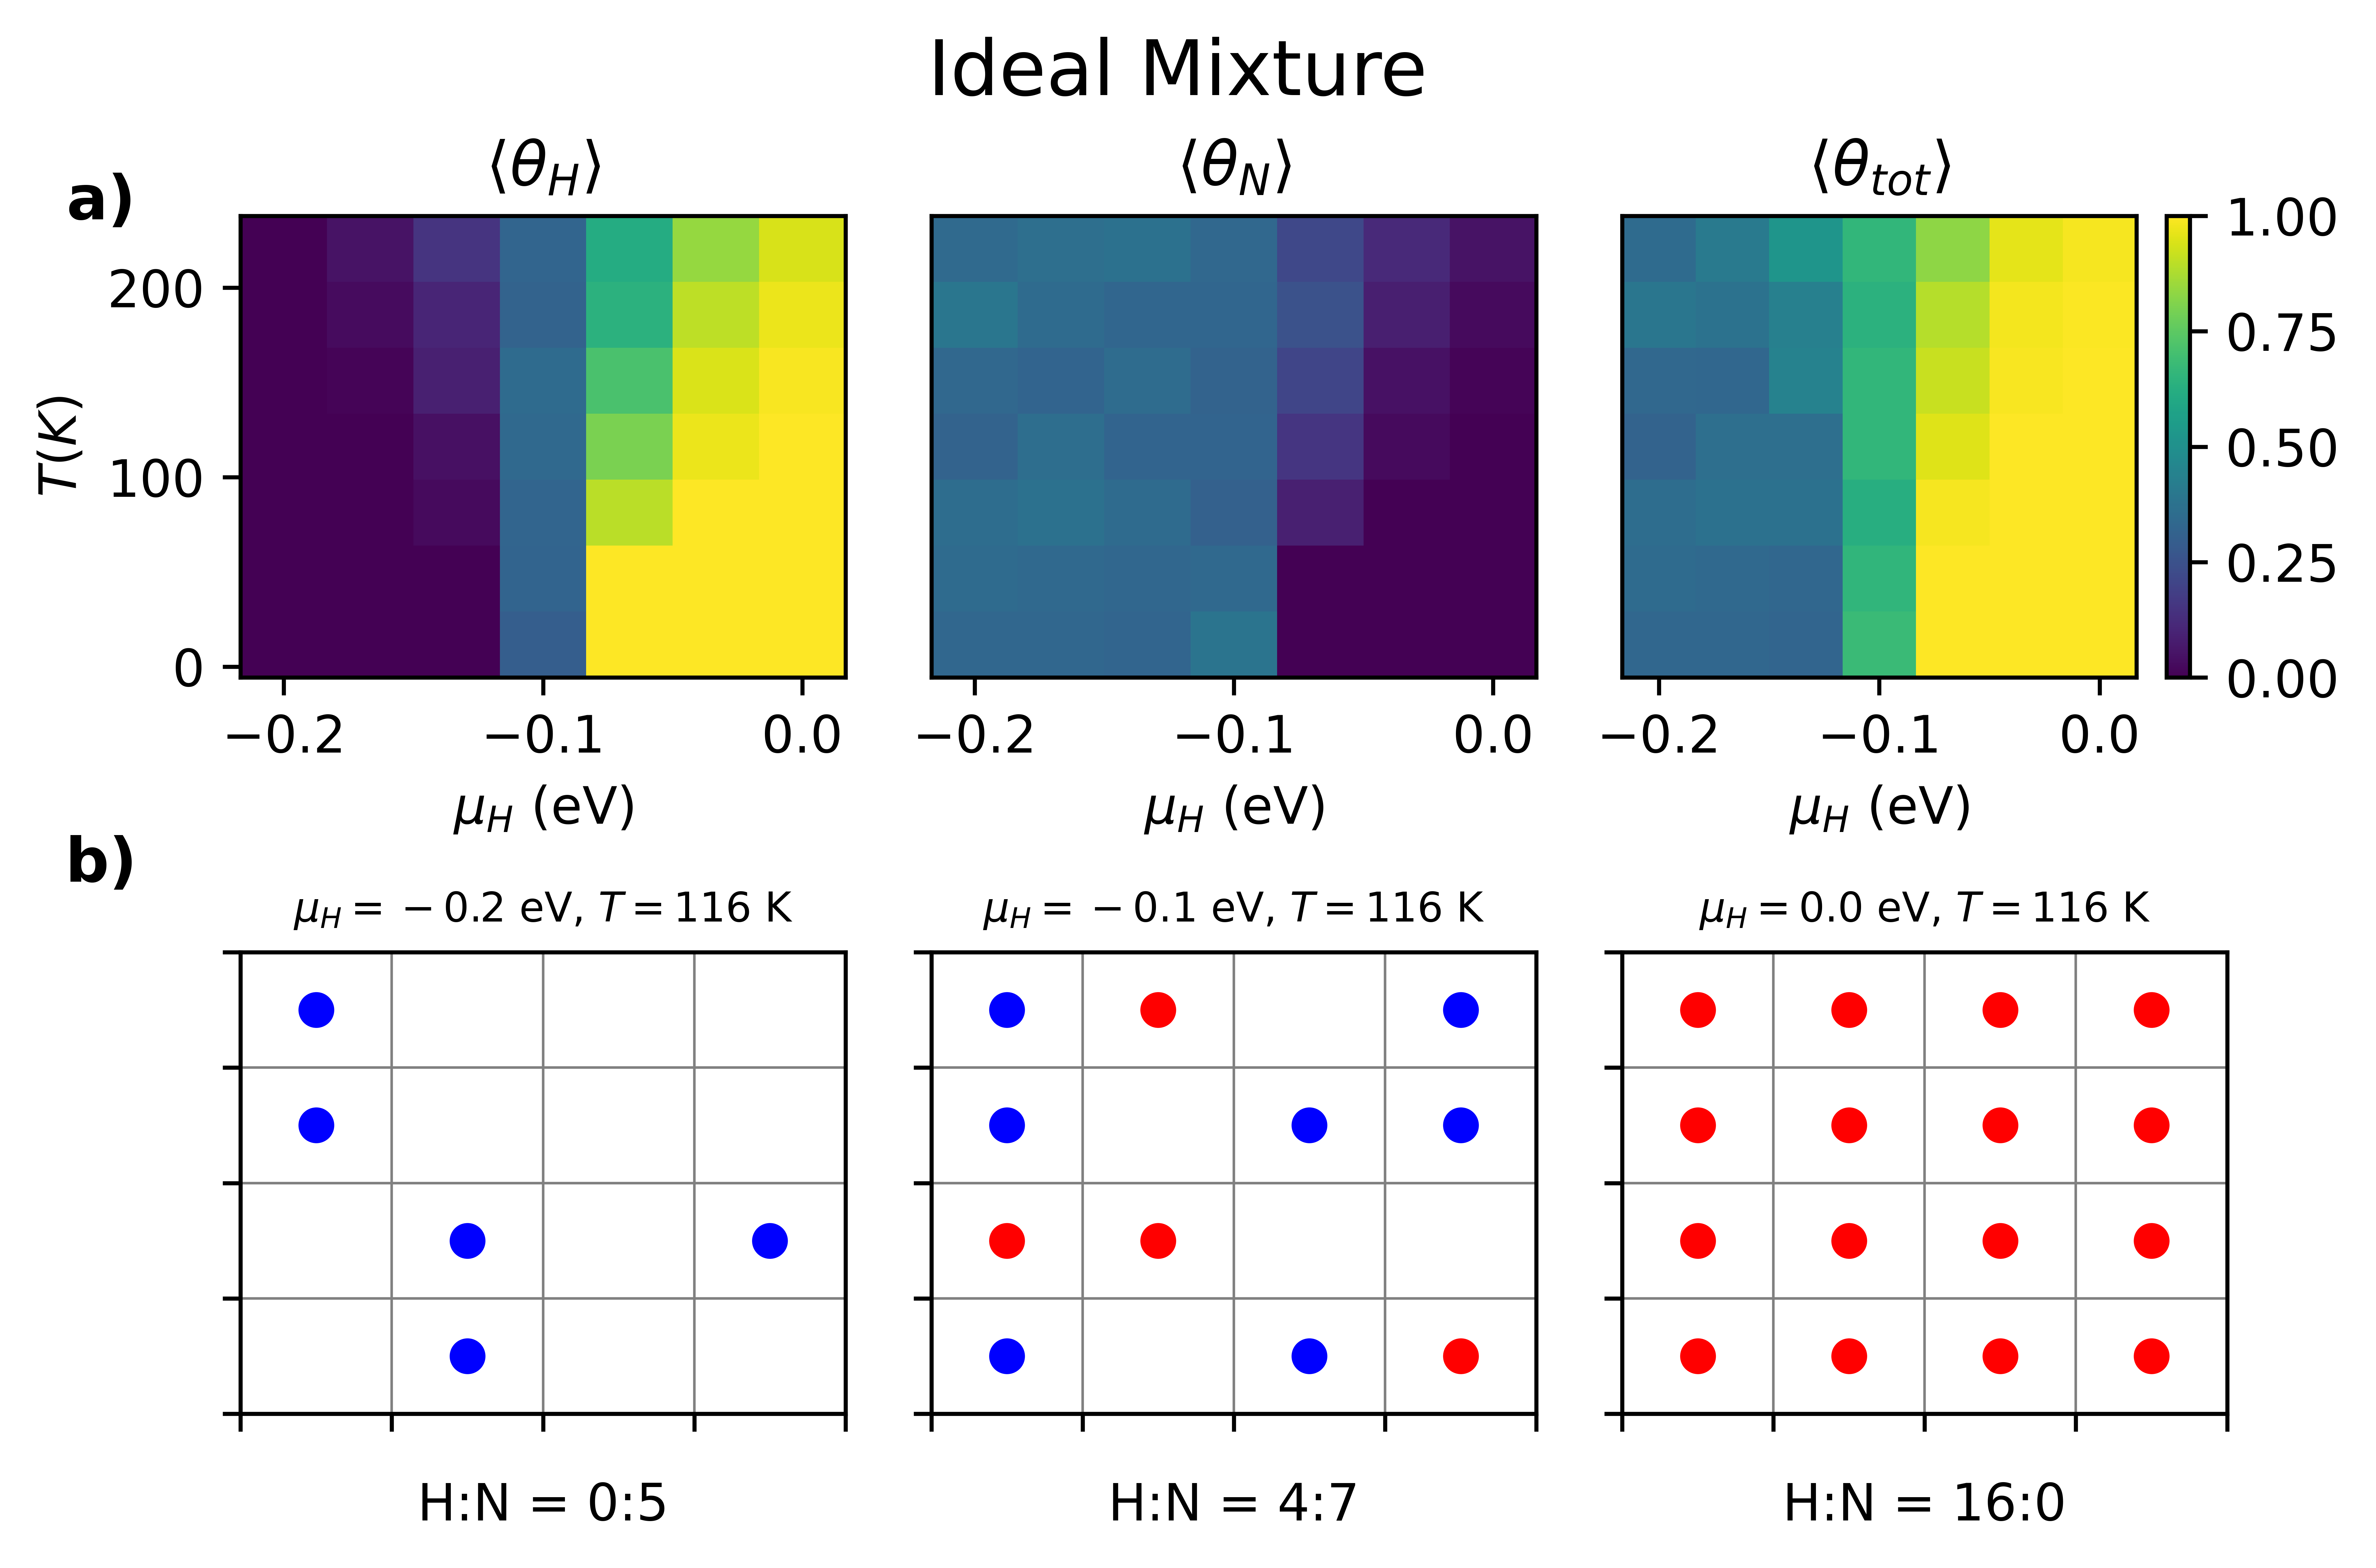

Plot saved as plots\Ideal Mixture\Phase_Diagram_Ideal Mixture_Tf_0.019_n_7.tiff
Plot saved as plots\Ideal Mixture\Table_Ideal Mixture.tiff


C:\Users\olivia\AppData\Local\Temp\ipykernel_13068\2209113994.py:202: RuntimeWarning: divide by zero encountered in scalar divide
  fraction = total_H/total_N


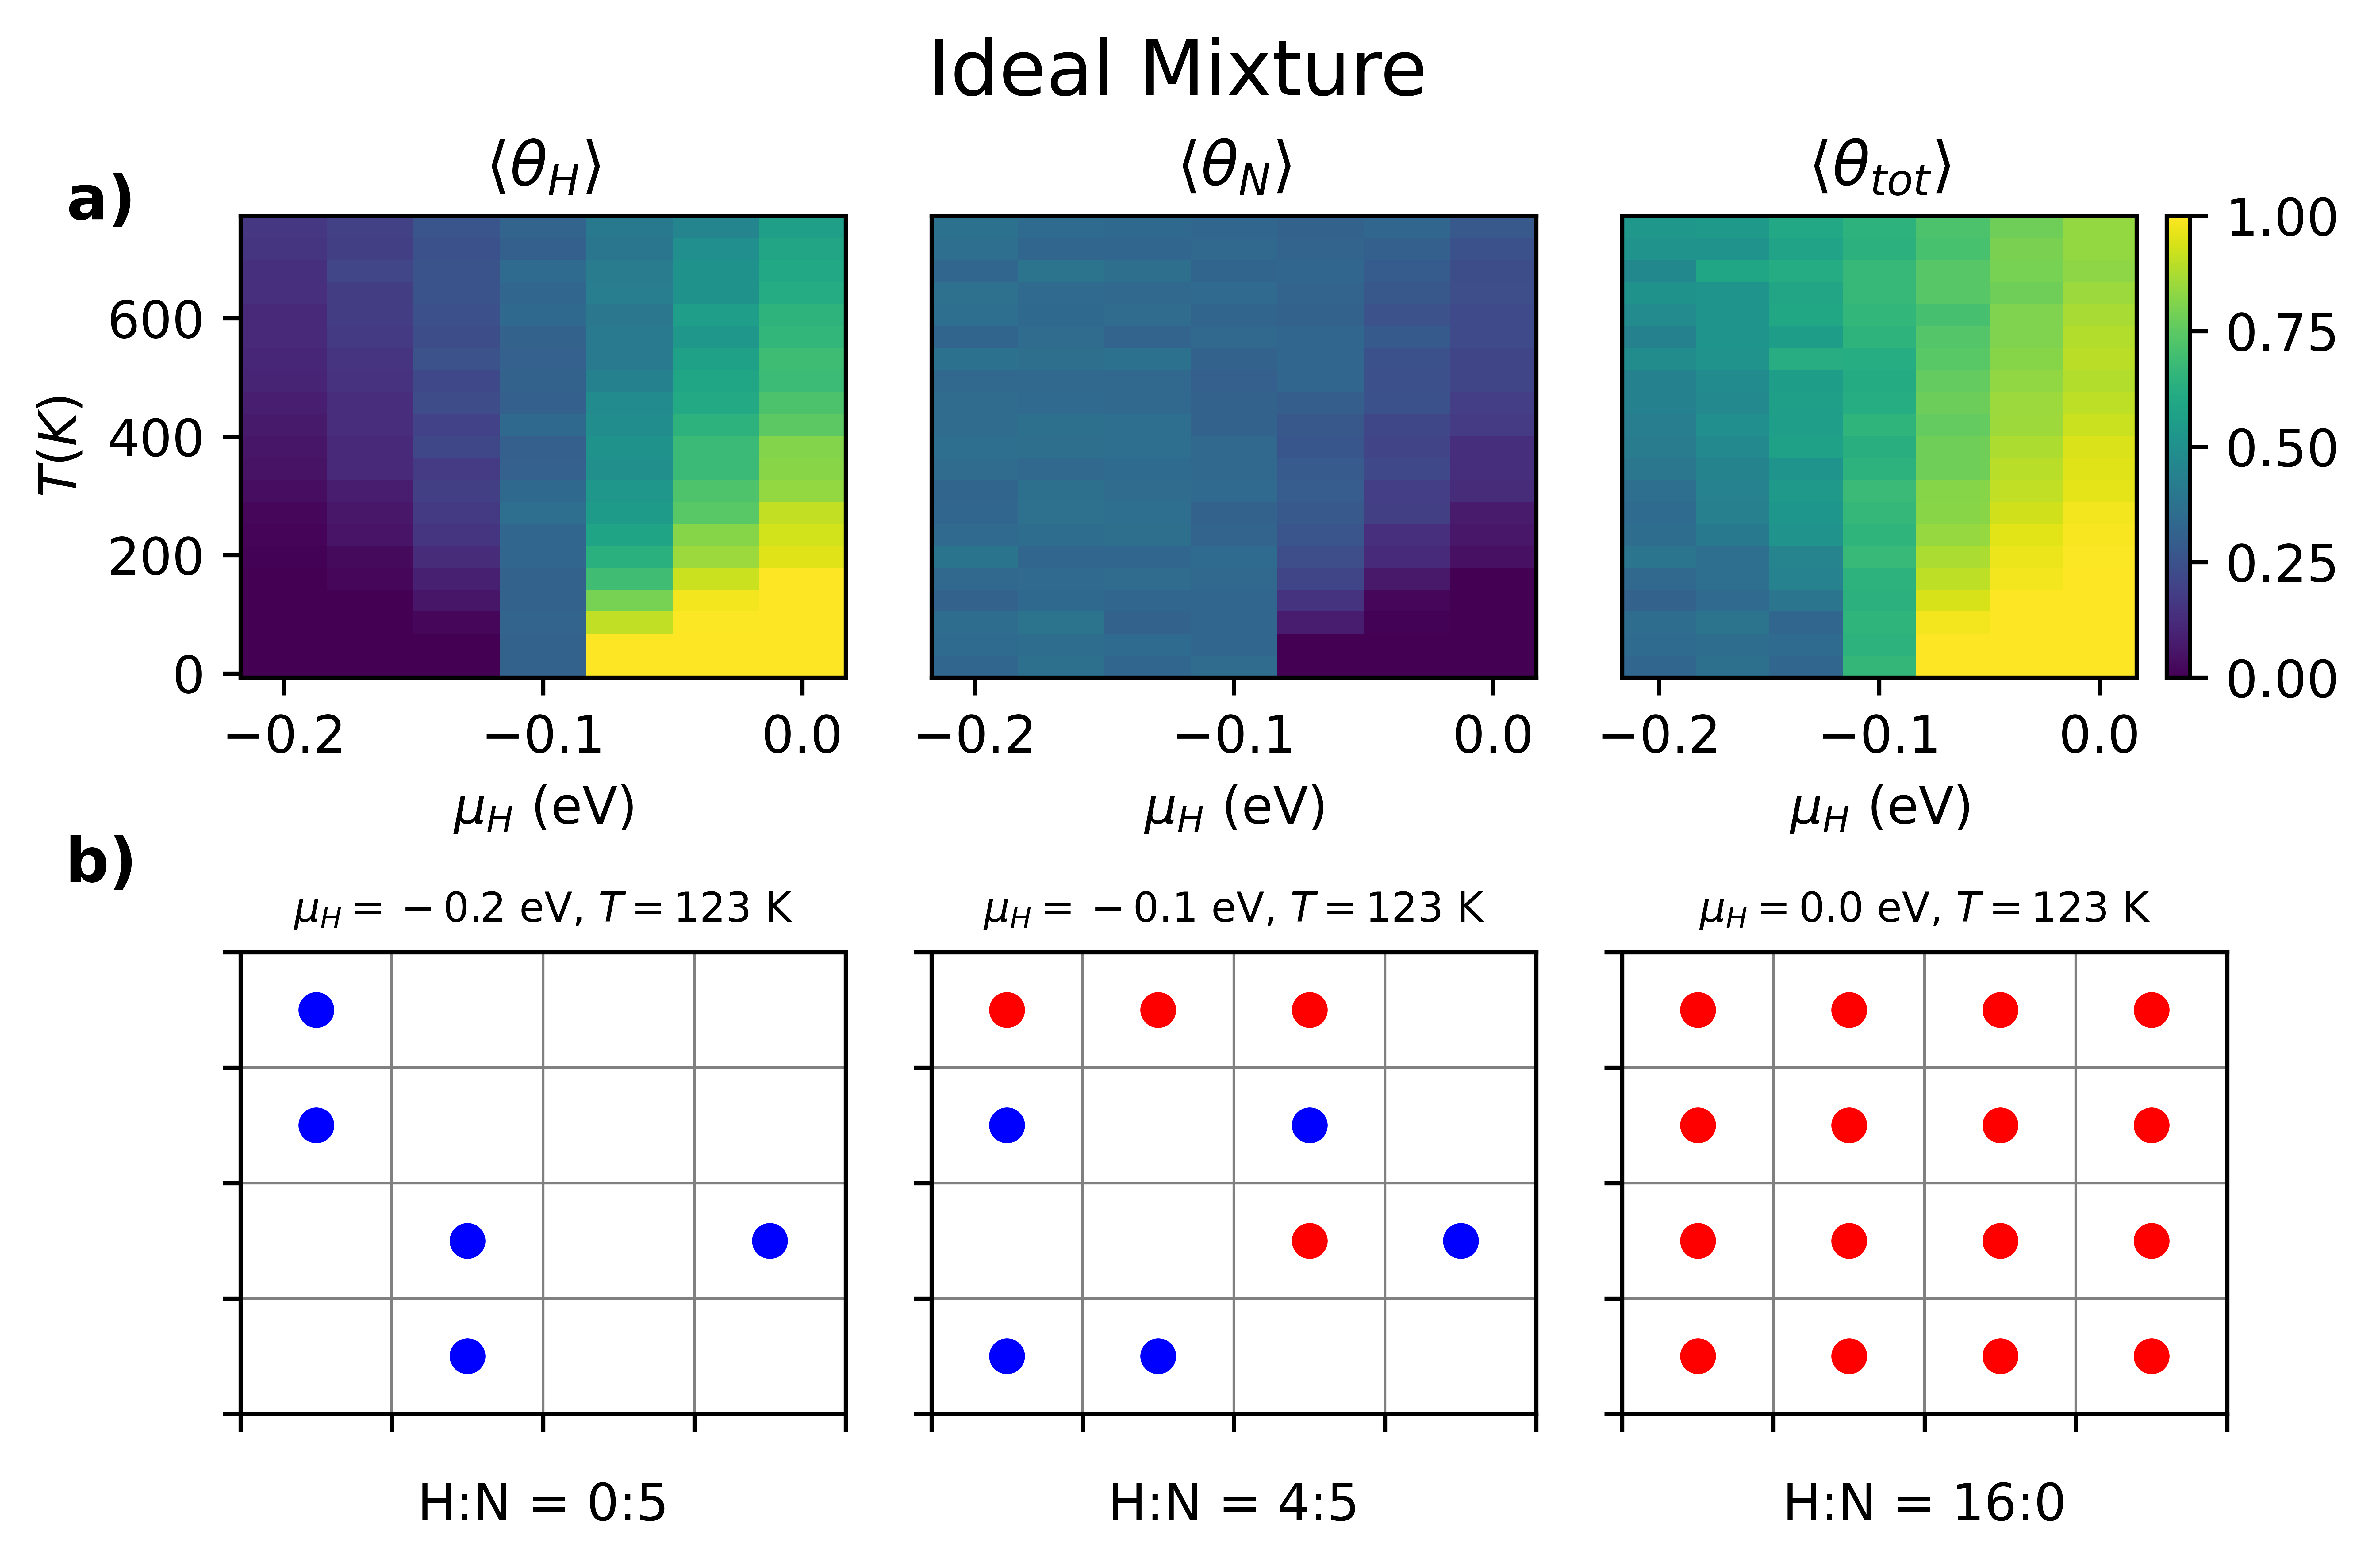

Plot saved as plots\Ideal Mixture\Phase_Diagram_Ideal Mixture_Tf_0.065_n_21.tiff
Plot saved as plots\Ideal Mixture\Table_Ideal Mixture.tiff


In [56]:
#Ideal Mixture
import numpy as np


runs = [
    {"Tf":0.019, "n": 7},
    {"Tf":0.065, "n": 21}
]
for idx, run in enumerate(runs, start=1):
    size = 4
    n_steps = 10000
    mus_A = np.linspace(-0.2, 0, 7)
    Ti=0.001
    Tf=run["Tf"]
    n=run["n"]
    Ts = np.linspace(Ti, Tf, n)

    params = []
    for mu_A in mus_A:
        for T in Ts:
            params.append({
                'epsilon_A': -0.1,
                'epsilon_B': -0.1,
                'epsilon_AA': 0,
                'epsilon_BB': 0,
                'epsilon_AB': 0,
                'mu_A': mu_A,
                'mu_B': -0.1,
                'T': T  # Temperature (in units of k))
            })

    # Run the simulation
    np.random.seed(42)
    final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
    mean_coverage_H = np.zeros((len(mus_A), len(Ts)))
    mean_coverage_N = np.zeros((len(mus_A), len(Ts)))
    for i, param in enumerate(params):
        lattice, coverage_H, coverage_N = run_simulation(size, n_steps, param)
        final_lattice[i // len(Ts), i % len(Ts)] = lattice
        mean_coverage_H[i // len(Ts), i % len(Ts)] = np.mean(coverage_H[-1000:])
        mean_coverage_N[i // len(Ts), i % len(Ts)] = np.mean(coverage_N[-1000:])

    Ts=Ts/(8.617*10**-5) #Convert to Kelvin

    # Plot the T-mu_A phase diagram
    fig, axs = plt.subplot_mosaic([[0, 1, 2], [3, 4, 5]], figsize=(6.5, 4.5),dpi=1200)
    fontisize=8
    # Mean coverage of H
    axs[0].pcolormesh(mus_A, Ts, mean_coverage_H.T, cmap='viridis', vmin=0, vmax=1)
    axs[0].set_title(r'$\langle \theta_H \rangle$')
    axs[0].set_xlabel(r'$\mu_H$ (eV)')
    axs[0].set_ylabel(r'$T(K)$')

    # Mean coverage of N
    axs[1].pcolormesh(mus_A, Ts, mean_coverage_N.T, cmap='viridis', vmin=0, vmax=1)
    axs[1].set_title(r'$\langle \theta_N \rangle$')
    axs[1].set_xlabel(r'$\mu_H$ (eV)')
    axs[1].set_yticks([])

    # Mean total coverage
    cax = axs[2].pcolormesh(mus_A, Ts, mean_coverage_H.T + mean_coverage_N.T, cmap='viridis', vmin=0, vmax=1)
    axs[2].set_title(r'$\langle \theta_{tot}\rangle$')
    axs[2].set_xlabel(r'$\mu_H$ (eV)')
    axs[2].set_yticks([])
    fig.colorbar(cax, ax=axs[2], location='right', fraction=0.1)
    fig.suptitle("Ideal Mixture", fontsize=15, y=0.95)

    fig.text(0.05, 0.85, 'a)', fontsize=12, fontweight='bold', ha='center', va='center')

    # mu_A = -0.2 eV and T = 0.01 / k
    axs[3] = plot_lattice(final_lattice[0, 3], axs[3], "")
    axs[3].set_title(rf'$\mu_H = {mus_A[0]}$ eV, $T = {Ts[3]:.0f}$ K', fontsize=fontisize)

    # mu_A = -0.1 eV and T = 0.01 / k
    axs[4] = plot_lattice(final_lattice[3, 3], axs[4],"")
    axs[4].set_title(rf'$\mu_H = {mus_A[3]}$ eV, $T = {Ts[3]:.0f}$ K', fontsize=fontisize)

    # mu_A = 0 eV and T = 0.01 / k
    axs[5] = plot_lattice(final_lattice[6, 3], axs[5], "")
    axs[5].set_title(rf'$\mu_H = {mus_A[6]}$ eV, $T = {Ts[3]:.0f}$ K', fontsize=fontisize)

    fig.text(0.05, 0.45, 'b)', fontsize=12, fontweight='bold', ha='center', va='center')

    plt.tight_layout()
    plt.show()

    save_Phase_Lattice(fig,"Ideal Mixture",run)
    optimal_conditions= find_optimal_conditions(mus_A,Ts,final_lattice)
    create_table(optimal_conditions, "Ideal Mixture")
    save_plots(optimal_conditions,final_lattice)



C:\Users\olivia\AppData\Local\Temp\ipykernel_13068\665476357.py:202: RuntimeWarning: divide by zero encountered in scalar divide
  fraction = total_H/total_N


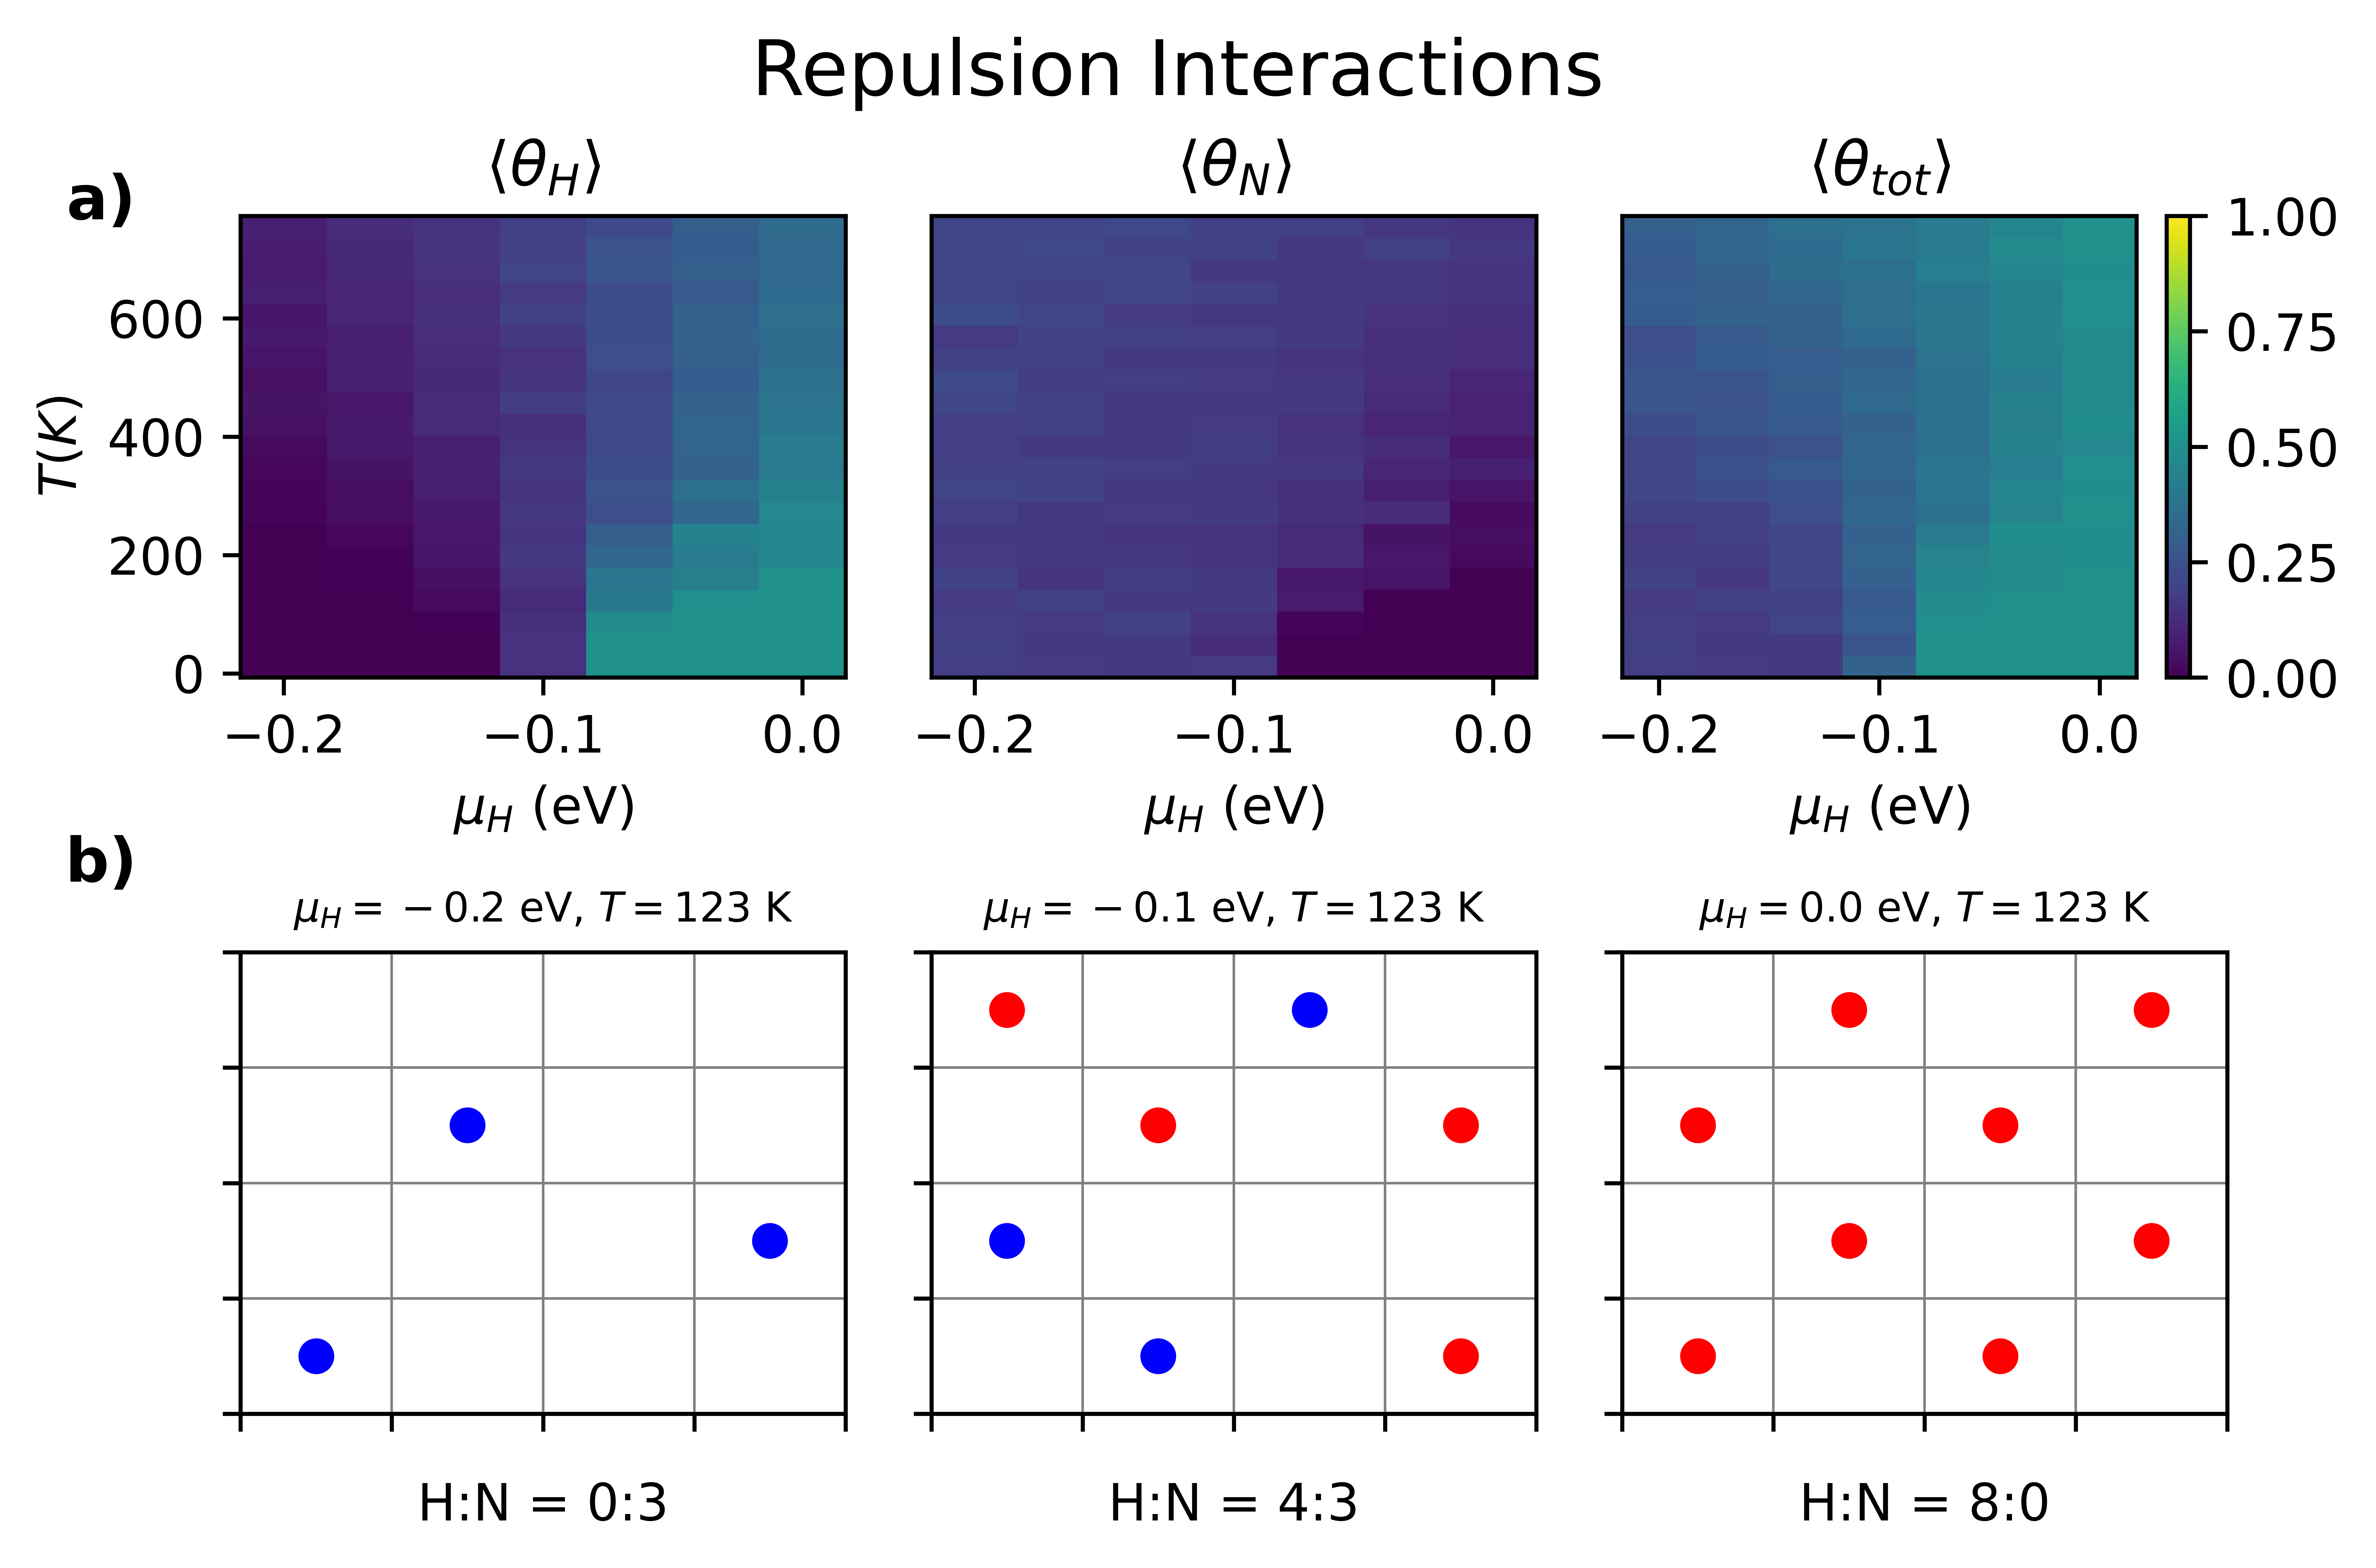

Plot saved as plots\Repulsion Interactions\Phase+Lattice_Repulsion Interactions.tiff
Plot saved as plots\Repulsion Interactions\Table_Repulsion Interactions.tiff


In [63]:
import numpy as np
import matplotlib.pyplot as plt

#A=Hydrogen->Varying value, limiting reagent
#B=Nitrogen->Constant value, excess 

# Parameters
size = 4
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7)
Ts = np.linspace(0.001, 0.065, 21)

params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1,
            'epsilon_B': -0.1,
            'epsilon_AA': 0.05,
            'epsilon_BB': 0.05,
            'epsilon_AB': 0.05,
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k))
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_H = np.zeros((len(mus_A), len(Ts)))
mean_coverage_N = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_H, coverage_N = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_H[i // len(Ts), i % len(Ts)] = np.mean(coverage_H[-1000:])
    mean_coverage_N[i // len(Ts), i % len(Ts)] = np.mean(coverage_N[-1000:])

Ts=Ts/(8.617*10**-5) #Convert to Kelvin

Title="Repulsion Interactions"

# Plot the T-mu_A phase diagram
fig, axs = plt.subplot_mosaic([[0, 1, 2], [3, 4, 5]], figsize=(6.5, 4.5),dpi=1200)
fontisize=8
# Mean coverage of H
axs[0].pcolormesh(mus_A, Ts, mean_coverage_H.T, cmap='viridis', vmin=0, vmax=1)
axs[0].set_title(r'$\langle \theta_H \rangle$')
axs[0].set_xlabel(r'$\mu_H$ (eV)')
axs[0].set_ylabel(r'$T(K)$')

# Mean coverage of N
axs[1].pcolormesh(mus_A, Ts, mean_coverage_N.T, cmap='viridis', vmin=0, vmax=1)
axs[1].set_title(r'$\langle \theta_N \rangle$')
axs[1].set_xlabel(r'$\mu_H$ (eV)')
axs[1].set_yticks([])

# Mean total coverage
cax = axs[2].pcolormesh(mus_A, Ts, mean_coverage_H.T + mean_coverage_N.T, cmap='viridis', vmin=0, vmax=1)
axs[2].set_title(r'$\langle \theta_{tot}\rangle$')
axs[2].set_xlabel(r'$\mu_H$ (eV)')
axs[2].set_yticks([])
fig.colorbar(cax, ax=axs[2], location='right', fraction=0.1)
fig.suptitle(Title, fontsize=15, y=0.95)

fig.text(0.05, 0.85, 'a)', fontsize=12, fontweight='bold', ha='center', va='center')

# mu_A = -0.2 eV and T = 0.01 / k
axs[3] = plot_lattice(final_lattice[0, 3], axs[3], "")
axs[3].set_title(rf'$\mu_H = {mus_A[0]}$ eV, $T = {Ts[3]:.0f}$ K', fontsize=fontisize)

# mu_A = -0.1 eV and T = 0.01 / k
axs[4] = plot_lattice(final_lattice[3, 3], axs[4],"")
axs[4].set_title(rf'$\mu_H = {mus_A[3]}$ eV, $T = {Ts[3]:.0f}$ K', fontsize=fontisize)

# mu_A = 0 eV and T = 0.01 / k
axs[5] = plot_lattice(final_lattice[6, 3], axs[5], "")
axs[5].set_title(rf'$\mu_H = {mus_A[6]}$ eV, $T = {Ts[3]:.0f}$ K', fontsize=fontisize)

fig.text(0.05, 0.45, 'b)', fontsize=12, fontweight='bold', ha='center', va='center')

plt.tight_layout()
plt.show()

save_Phase_Lattice(fig,Title)
optimal_conditions= find_optimal_conditions(mus_A,Ts,final_lattice)
create_table(optimal_conditions, Title)
save_plots(optimal_conditions,final_lattice,Title)



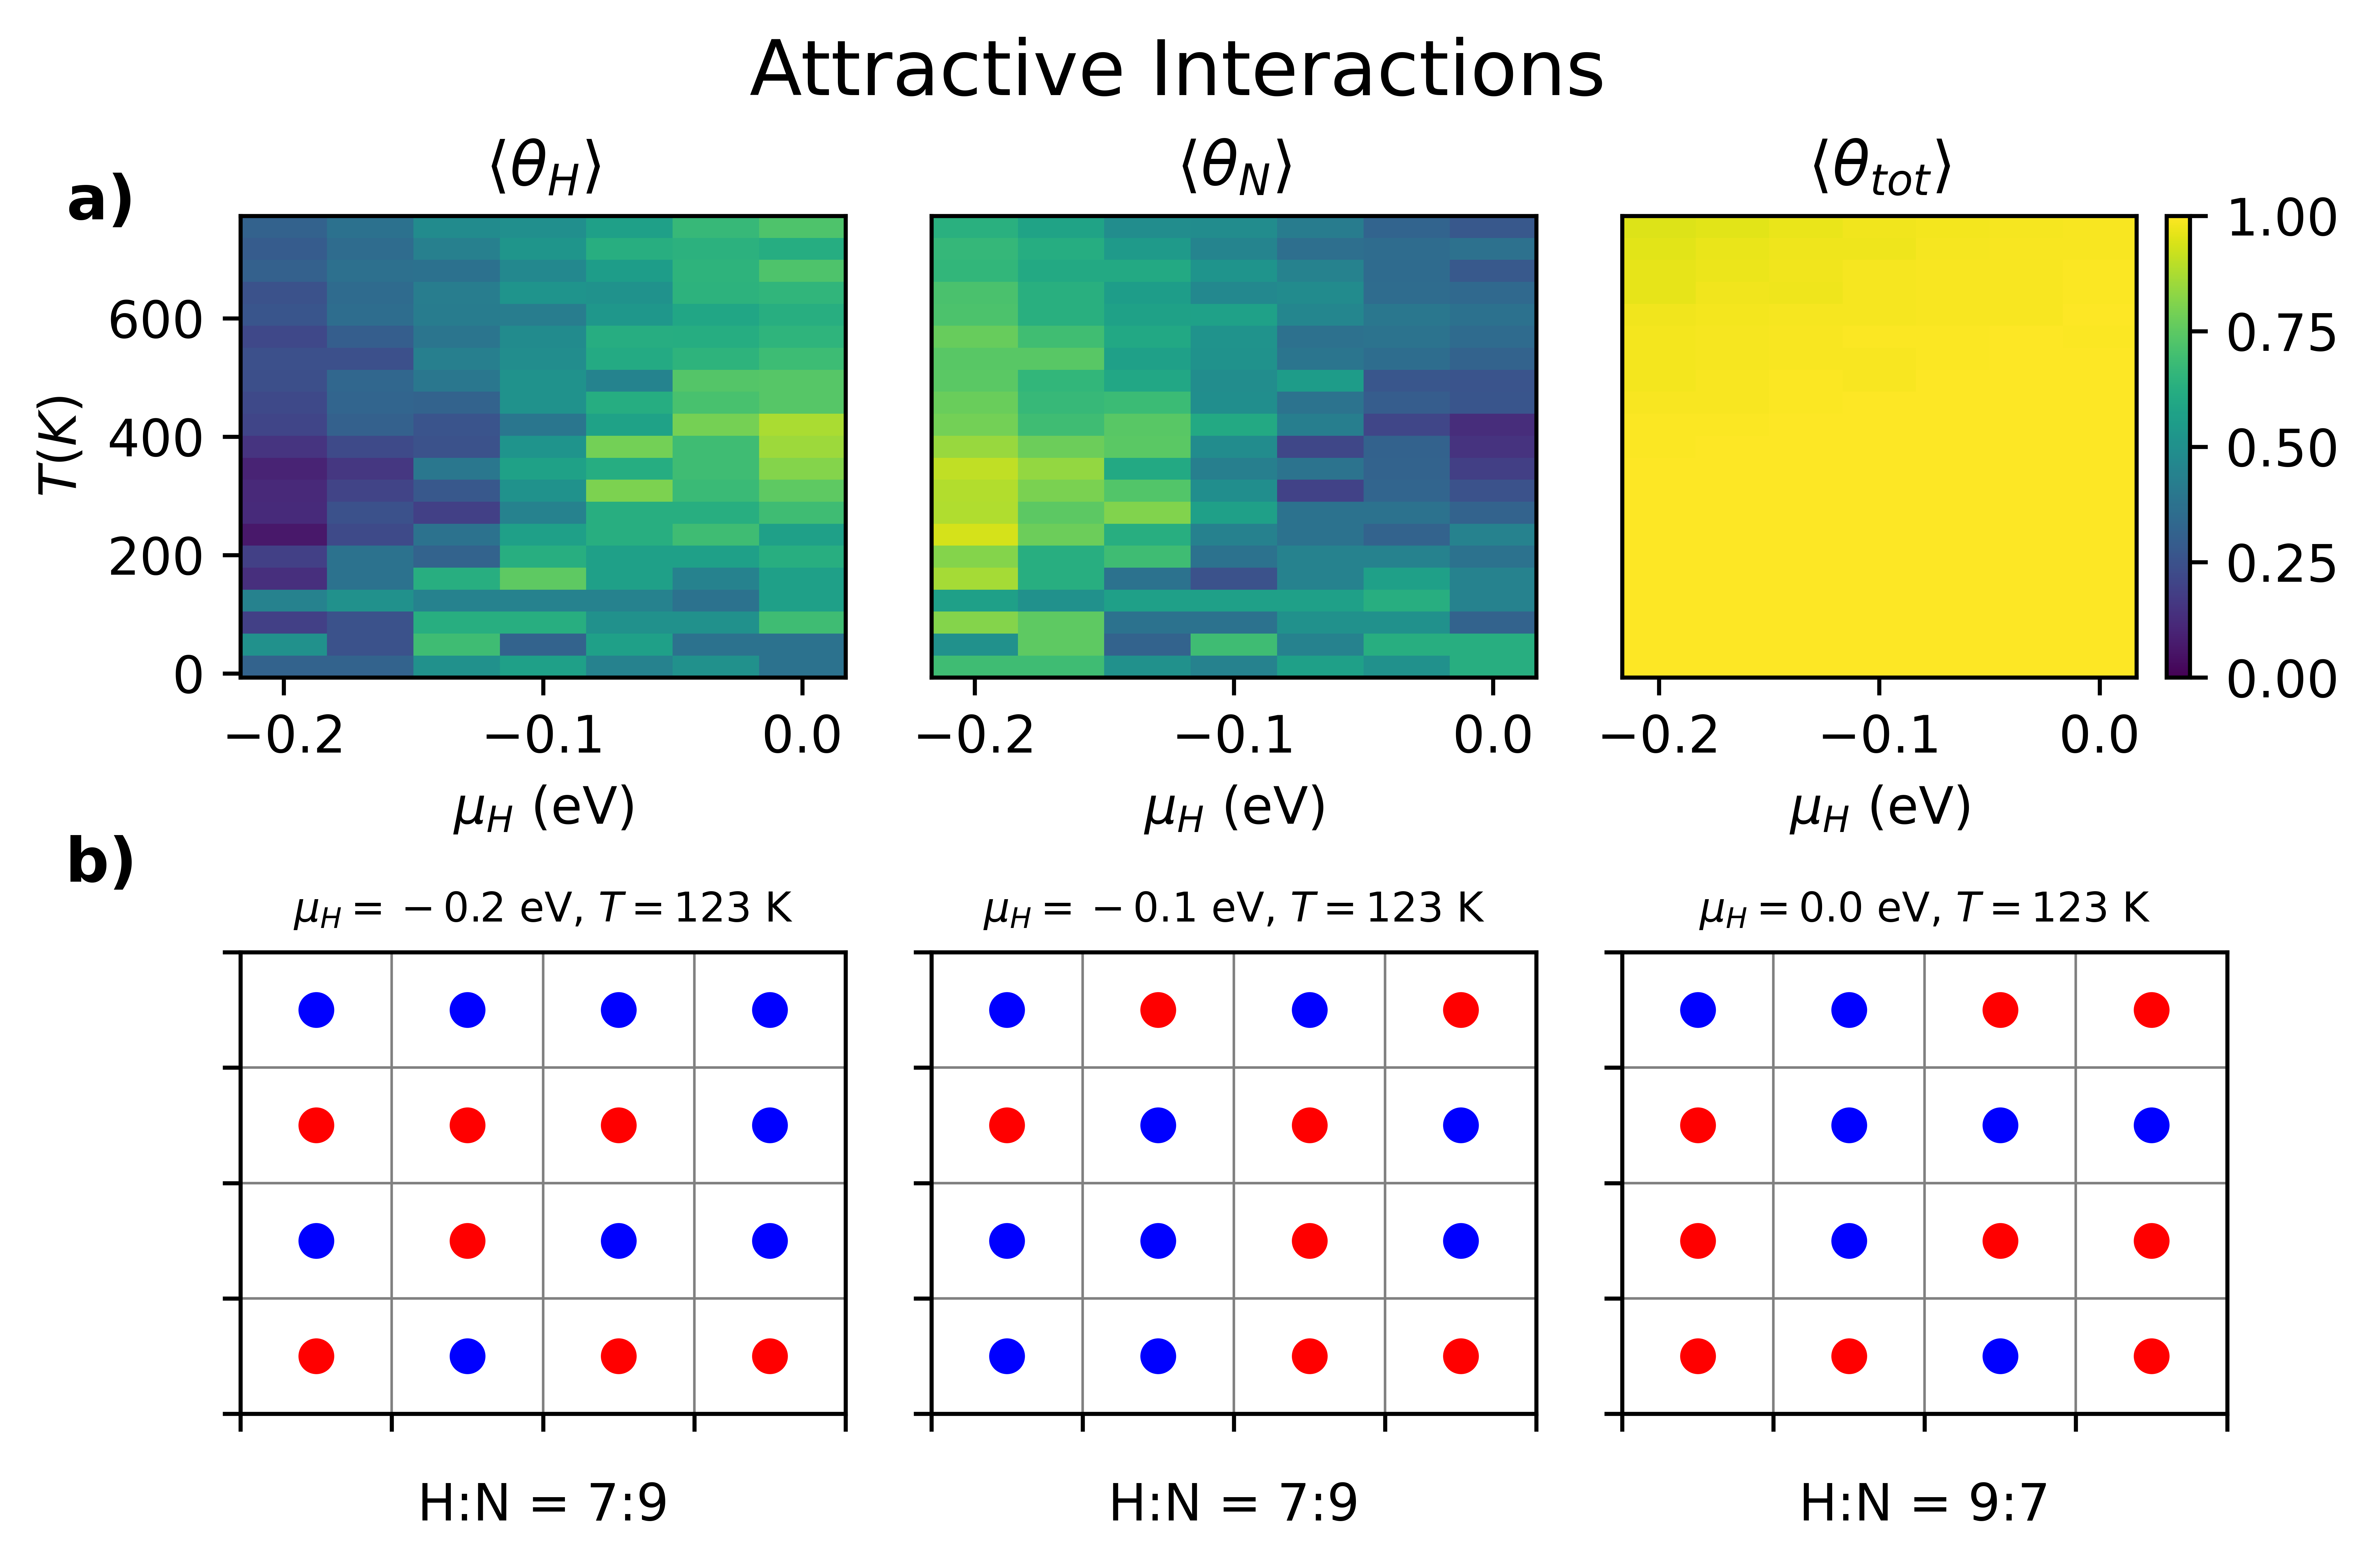

Plot saved as plots\Attractive Interactions\Phase+Lattice_Attractive Interactions.tiff
Plot saved as plots\Attractive Interactions\Table_Attractive Interactions.tiff


In [65]:
#attractive Interactions

import numpy as np
import matplotlib.pyplot as plt

# Parameters
size = 4
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7)
Ts = np.linspace(0.001, 0.065, 21)

params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1,
            'epsilon_B': -0.1,
            'epsilon_AA': -0.05,
            'epsilon_BB': -0.05,
            'epsilon_AB': -0.05,
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k))
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_H = np.zeros((len(mus_A), len(Ts)))
mean_coverage_N = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_H, coverage_N = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_H[i // len(Ts), i % len(Ts)] = np.mean(coverage_H[-1000:])
    mean_coverage_N[i // len(Ts), i % len(Ts)] = np.mean(coverage_N[-1000:])

Ts=Ts/(8.617*10**-5) #Convert to Kelvin

Title="Attractive Interactions"

# Plot the T-mu_A phase diagram
fig, axs = plt.subplot_mosaic([[0, 1, 2], [3, 4, 5]], figsize=(6.5, 4.5),dpi=1200)
fontisize=8
# Mean coverage of H
axs[0].pcolormesh(mus_A, Ts, mean_coverage_H.T, cmap='viridis', vmin=0, vmax=1)
axs[0].set_title(r'$\langle \theta_H \rangle$')
axs[0].set_xlabel(r'$\mu_H$ (eV)')
axs[0].set_ylabel(r'$T(K)$')

# Mean coverage of N
axs[1].pcolormesh(mus_A, Ts, mean_coverage_N.T, cmap='viridis', vmin=0, vmax=1)
axs[1].set_title(r'$\langle \theta_N \rangle$')
axs[1].set_xlabel(r'$\mu_H$ (eV)')
axs[1].set_yticks([])

# Mean total coverage
cax = axs[2].pcolormesh(mus_A, Ts, mean_coverage_H.T + mean_coverage_N.T, cmap='viridis', vmin=0, vmax=1)
axs[2].set_title(r'$\langle \theta_{tot}\rangle$')
axs[2].set_xlabel(r'$\mu_H$ (eV)')
axs[2].set_yticks([])
fig.colorbar(cax, ax=axs[2], location='right', fraction=0.1)
fig.suptitle(Title, fontsize=15, y=0.95)

fig.text(0.05, 0.85, 'a)', fontsize=12, fontweight='bold', ha='center', va='center')

# mu_A = -0.2 eV and T = 0.01 / k
axs[3] = plot_lattice(final_lattice[0, 3], axs[3], "")
axs[3].set_title(rf'$\mu_H = {mus_A[0]}$ eV, $T = {Ts[3]:.0f}$ K', fontsize=fontisize)

# mu_A = -0.1 eV and T = 0.01 / k
axs[4] = plot_lattice(final_lattice[3, 3], axs[4],"")
axs[4].set_title(rf'$\mu_H = {mus_A[3]}$ eV, $T = {Ts[3]:.0f}$ K', fontsize=fontisize)

# mu_A = 0 eV and T = 0.01 / k
axs[5] = plot_lattice(final_lattice[6, 3], axs[5], "")
axs[5].set_title(rf'$\mu_H = {mus_A[6]}$ eV, $T = {Ts[3]:.0f}$ K', fontsize=fontisize)

fig.text(0.05, 0.45, 'b)', fontsize=12, fontweight='bold', ha='center', va='center')

plt.tight_layout()
plt.show()

save_Phase_Lattice(fig,Title)
optimal_conditions= find_optimal_conditions(mus_A,Ts,final_lattice)
create_table(optimal_conditions, Title)
save_plots(optimal_conditions,final_lattice, Title)

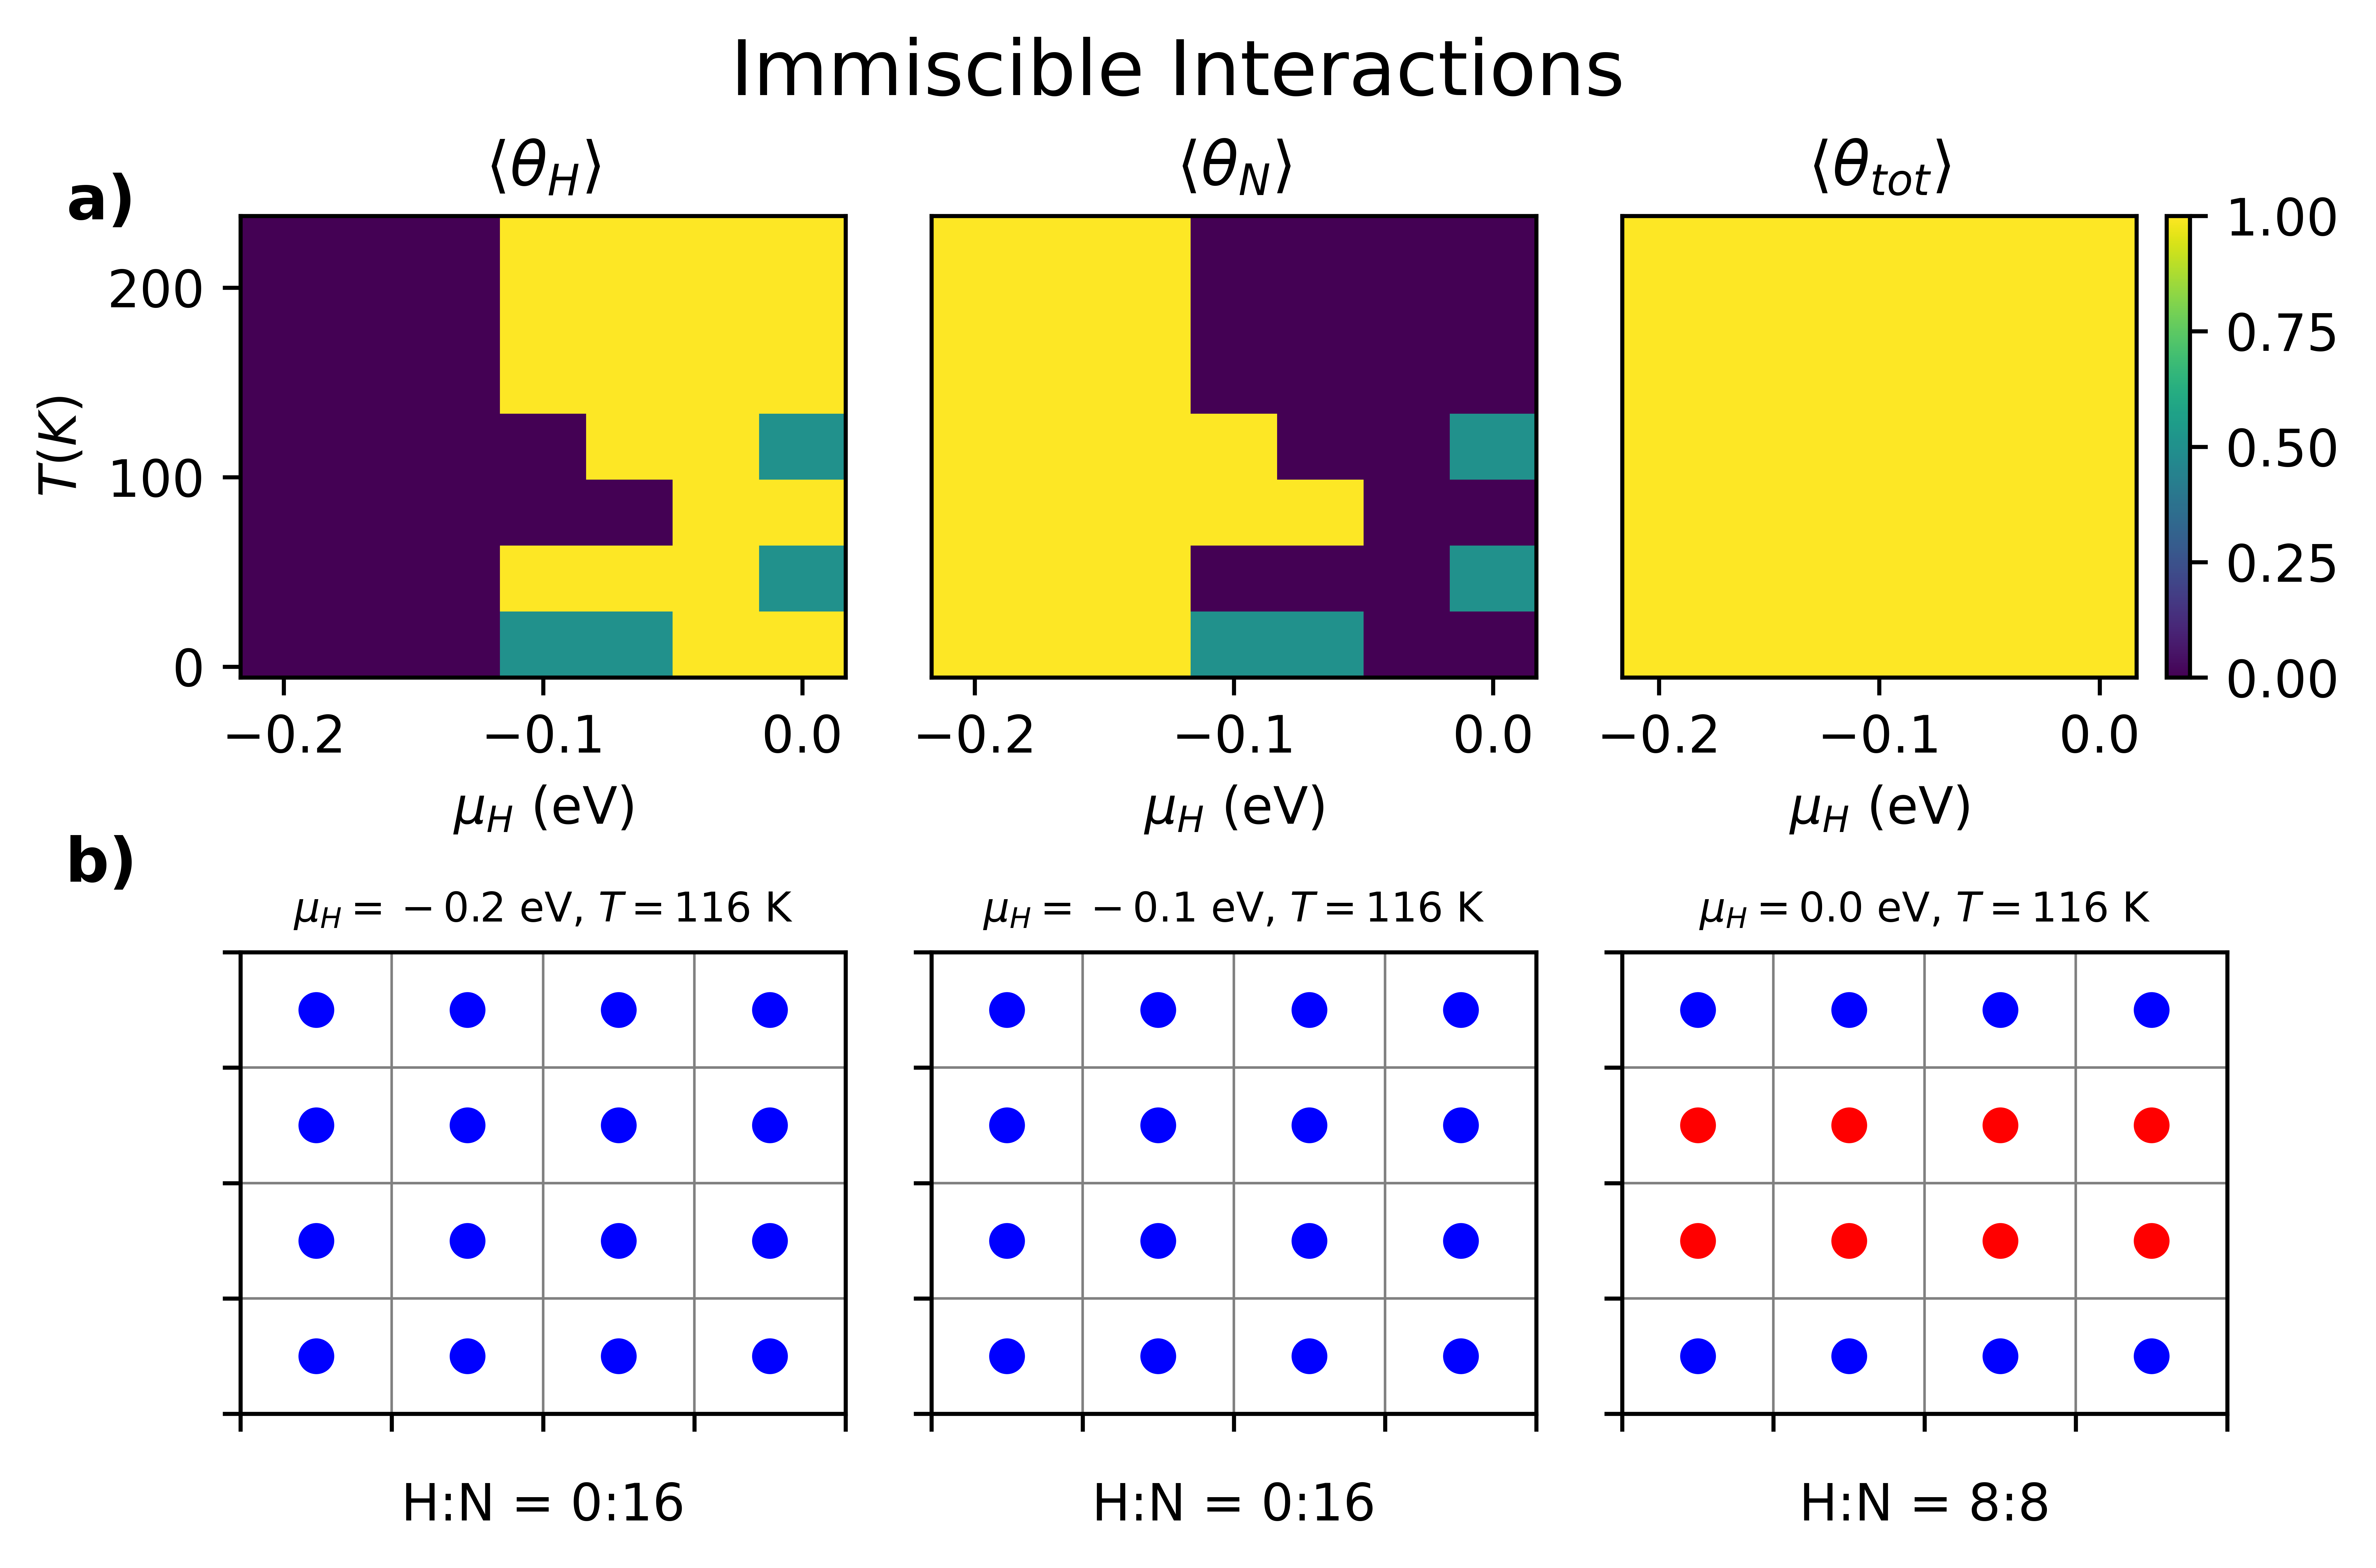

Plot saved as plots\Immiscible Interactions\Phase+Lattice_Immiscible Interactions.tiff
Table not created, no optimal conditions.


In [86]:
#Immiscible Nitrogen and Hydrogen 

import numpy as np
import matplotlib.pyplot as plt

#A=Hydrogen->Varying value, limiting reagent
#B=Nitrogen->Constant value, excess 

# Parameters
size = 4
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7)
Ts = np.linspace(0.001, 0.019, 7)

params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1,
            'epsilon_B': -0.1,
            'epsilon_AA': -0.05,
            'epsilon_BB': -0.05,
            'epsilon_AB': 0.05,
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k))
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_H = np.zeros((len(mus_A), len(Ts)))
mean_coverage_N = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_H, coverage_N = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_H[i // len(Ts), i % len(Ts)] = np.mean(coverage_H[-1000:])
    mean_coverage_N[i // len(Ts), i % len(Ts)] = np.mean(coverage_N[-1000:])

Ts=Ts/(8.617*10**-5) #Convert to Kelvin

Title="Immiscible Interactions"

# Plot the T-mu_A phase diagram
fig, axs = plt.subplot_mosaic([[0, 1, 2], [3, 4, 5]], figsize=(6.5, 4.5),dpi=1200)
fontisize=8
# Mean coverage of H
axs[0].pcolormesh(mus_A, Ts, mean_coverage_H.T, cmap='viridis', vmin=0, vmax=1)
axs[0].set_title(r'$\langle \theta_H \rangle$')
axs[0].set_xlabel(r'$\mu_H$ (eV)')
axs[0].set_ylabel(r'$T(K)$')

# Mean coverage of N
axs[1].pcolormesh(mus_A, Ts, mean_coverage_N.T, cmap='viridis', vmin=0, vmax=1)
axs[1].set_title(r'$\langle \theta_N \rangle$')
axs[1].set_xlabel(r'$\mu_H$ (eV)')
axs[1].set_yticks([])

# Mean total coverage
cax = axs[2].pcolormesh(mus_A, Ts, mean_coverage_H.T + mean_coverage_N.T, cmap='viridis', vmin=0, vmax=1)
axs[2].set_title(r'$\langle \theta_{tot}\rangle$')
axs[2].set_xlabel(r'$\mu_H$ (eV)')
axs[2].set_yticks([])
fig.colorbar(cax, ax=axs[2], location='right', fraction=0.1)
fig.suptitle(Title, fontsize=15, y=0.95)

fig.text(0.05, 0.85, 'a)', fontsize=12, fontweight='bold', ha='center', va='center')

# mu_A = -0.2 eV and T = 0.01 / k
axs[3] = plot_lattice(final_lattice[0, 3], axs[3], "")
axs[3].set_title(rf'$\mu_H = {mus_A[0]}$ eV, $T = {Ts[3]:.0f}$ K', fontsize=fontisize)

# mu_A = -0.1 eV and T = 0.01 / k
axs[4] = plot_lattice(final_lattice[3, 3], axs[4],"")
axs[4].set_title(rf'$\mu_H = {mus_A[3]}$ eV, $T = {Ts[3]:.0f}$ K', fontsize=fontisize)

# mu_A = 0 eV and T = 0.01 / k
axs[5] = plot_lattice(final_lattice[6, 3], axs[5], "")
axs[5].set_title(rf'$\mu_H = {mus_A[6]}$ eV, $T = {Ts[3]:.0f}$ K', fontsize=fontisize)

fig.text(0.05, 0.45, 'b)', fontsize=12, fontweight='bold', ha='center', va='center')

plt.tight_layout()
plt.show()

save_Phase_Lattice(fig,Title)
optimal_conditions= find_optimal_conditions(mus_A,Ts,final_lattice)

create_table(optimal_conditions, Title)
save_plots(optimal_conditions,final_lattice, Title)

In [87]:
print(optimal_conditions)
print(optimal_conditions.values)

{'pot_ind': [], 'mu_H': [], 'temp_ind': [], 'T': [], 'H:N_ratio': [], 'H:N_ratio_decimal': [], 'Coverage': []}
<built-in method values of dict object at 0x0000022648AD0040>
